<a href="https://colab.research.google.com/github/wondercha/cnn_experiment/blob/main/cnn_cifar10_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Module import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
use_duda = torch.cuda.is_available()
device = torch.device("cuda" if use_duda else "cpu")
print(device)

cpu


In [ ]:
# 전처리
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

In [ ]:
# # If running on Windows and you get a BrokenPipeError, try setting
# the num_worker of torch.utils.data.DataLoader() to 0.
train_loader = torch.utils.data.DataLoader(trainset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=2)
test_loader = DataLoader(testset,
                        batch_size =16,
                        shuffle=False,
                        num_workers=2)

In [ ]:
# Define class
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
# CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3), # 30
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)  #15
            #nn.Dropout(0.5)  
            
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  #14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)  #7
            #nn.Dropout(0.5)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), #6
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),  #3
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Linear(128*3*3, 400),
            nn.Linear(400, 120),
            nn.Linear(120, 10)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1, 128*3*3)
        x = self.layer4(x)
        return x


In [ ]:
net = Net() #.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Time Check
import timeit
start_time = timeit.default_timer() # 시작 시간 체크

epochs = 30
steps = 0

train_losses, test_losses = [], []
train_accuracy, test_accuracy = [], []
for e in range(epochs):
    running_loss = 0
    running_acc = 0
    running_total = 0
    for images, labels in train_loader:

        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_total += labels.size(0)
        running_acc += (preds == labels.data).sum().item()

    # for 문이 끝나면 실행한다.
    else:
        test_loss = 0
        accuracy = 0
        total = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = net(images)
                test_loss += criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                accuracy += (predicted == labels).sum().item()

        train_losses.append(running_loss/len(train_loader))
        train_accuracy.append(running_acc/running_total)
        test_losses.append(test_loss/len(test_loader))
        test_accuracy.append(accuracy/total)
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Training Accuracy: {:.3f}.. ".format(running_acc/running_total),
              "Test Accuracy: {:.3f}".format(accuracy/total))

print('Finished Training...')

# Waits for everything to finish running 
terminate_time = timeit.default_timer() # 종료 시간 체크  
print("%f sec" % (terminate_time - start_time))

Epoch: 1/30..  Training Loss: 1.286..  Test Loss: 1.030..  Training Accuracy: 0.540..  Test Accuracy: 0.636
Epoch: 2/30..  Training Loss: 0.930..  Test Loss: 0.896..  Training Accuracy: 0.675..  Test Accuracy: 0.692
Epoch: 3/30..  Training Loss: 0.786..  Test Loss: 0.791..  Training Accuracy: 0.725..  Test Accuracy: 0.732
Epoch: 4/30..  Training Loss: 0.691..  Test Loss: 0.797..  Training Accuracy: 0.761..  Test Accuracy: 0.725
Epoch: 5/30..  Training Loss: 0.616..  Test Loss: 0.765..  Training Accuracy: 0.787..  Test Accuracy: 0.738
Epoch: 6/30..  Training Loss: 0.557..  Test Loss: 0.782..  Training Accuracy: 0.807..  Test Accuracy: 0.740
Epoch: 7/30..  Training Loss: 0.502..  Test Loss: 0.773..  Training Accuracy: 0.823..  Test Accuracy: 0.745
Epoch: 8/30..  Training Loss: 0.456..  Test Loss: 0.757..  Training Accuracy: 0.839..  Test Accuracy: 0.752
Epoch: 9/30..  Training Loss: 0.416..  Test Loss: 0.790..  Training Accuracy: 0.856..  Test Accuracy: 0.753
Epoch: 10/30..  Training Los

In [ ]:
import matplotlib.pyplot as plt
import datetime

current_dtime = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
rslt_fname = './data/loss_' + current_dtime + '.png'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

NameError: ignored

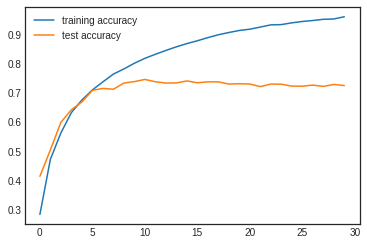

In [ ]:
plt.plot(train_accuracy, label='training accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.legend(frameon=False)
plt.show()